# Inspect results

In [1]:
import pickle
import os
import matplotlib.pyplot as plt

In [2]:
# Prediction margin: the only parameter to set. Recommended: margin in {5, 10, 15, 20} (aka 0.5, 1, 1.5, 2 seconds)
margin = 5

Traning summary of the model. Note: metrics are computed on validation set

Model:		 raw_signal
Features:	 differencing_Ax_min_w15
Seed:		 s200
Params_idx:	 p0
Params:		 {}
Best_cost:	 28.4
Best_threshold:	 3.0075389200598135
Cost:		 28.4
Anticipation:	 0.25
Detect_faults:	 6
Missed_faults:	 1
False_alarms:	 7


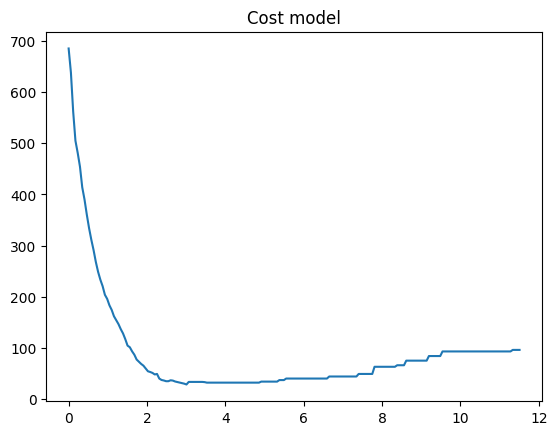

In [5]:
# file = "autoencoder-w5_features-s300-p1"
file = "raw_signal-differencing_Ax_min_w15-s200-p0"
with open("results_" + str(margin) + "/" + file, "rb") as f:
    model, feature, seed, params_idx = file.split("-")
    training_columns, params, history, best_cost, best_thr, all_cost, all_thr, perf = pickle.load(f)
    cost, ant, df, mf, fa = perf
    
    print("Traning summary of the model. Note: metrics are computed on validation set\n")
    print("Model:\t\t", model)
    print("Features:\t", feature)
    print("Seed:\t\t", seed)
    print("Params_idx:\t", params_idx)
    print("Params:\t\t", params)
    print("Best_cost:\t", best_cost)
    print("Best_threshold:\t", best_thr)
    print("Cost:\t\t", cost)
    print("Anticipation:\t", ant)
    print("Detect_faults:\t", df)
    print("Missed_faults:\t", mf)
    print("False_alarms:\t", fa)

    plt.title("Cost model")
    plt.plot(all_thr, all_cost)
    plt.show()

    if history is not None:
        plt.title("Loss")
        plt.plot(history.history["loss"])
        plt.plot(history.history["val_loss"])
        plt.show()